# NFT Mint Sweetspot
Data analysis on Solana NFT minting price and its impact on generated returns.

___
## Introduction
During the early months of the 2021 NFT craze, something just had to be minted and would most likely get sold out immediatly. Since then however, launching an NFT project has become a much more involved process where each part is carefully considered in order to maximize returns to the creators and the community.

In this report we will have a closer look at how the minting price of an NFT project and how that might influence the return achieved over time.

___
## Methodology
The data will cover the NFT collection statistics of projects on the Solana blockchain. Although there are many marketplaces operating on the network, we will only make use of data for projects that have been listed on the `Magic Eden` marketplace. This however should not skew the data too much as it is the greatest marketplace by trading volume and number of projects and should therefore reflect a relevant picture for the overall ecosystem.

The report will be built on four indicators:
- `mint price`: The NFT minting price of the collection.
- `floor price`: The smallest marketplace ask price for a listed piece from a collection.
- `trading volume`: The overall amount of SOL traded on the marketplace across all pieces of a collection.
- `roi`: Multiplication factor of the minting price to reach the current collection floor price.
- `mint cap`: Limit on the number of NFTs that can be minted by any individual wallet.

*All prices and trading volumes are expressed in SOL.*

The data will be obtained through two sources:
1. FlipsideCrypto: https://app.flipsidecrypto.com
2. Magic Eden API: https://api.magiceden.dev/

Once we have the data, we will join it all together into a Pandas DataFrame so we can plot and analyze it using Python. Below we have imported the necessary modules.

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Then we can build our DataFrames. Below we have the data extracted from the Magic Eden API which was transformed and cleaned in the `MagicEden_API_extraction.ipynb` notebook in the same directory. The `mint` field represents one random piece from each collection that will then be used to join the DataFrame with the other half of the data.

From the API we are left with **5,675 NFT Collections** along with their current floor price and all-time trading volume on the marketplace.

In [8]:
magiceden_df = pd.read_json('./data/magiceden_cleaned.json')
magiceden_df.reset_index(inplace=True, drop=True)
magiceden_df.head()

,symbol,floor_price,trading_volume,mint
0,sol_chocked_man,0.400,1.200000,CR2rcWaHWJgcMSzdewSs7S6QLryJZnt5eMQHQf9mQULS
1,_peguimonkey,0.380,27.740000,ByX4fiQNFjeHiL9xCXaee39XhWeptC5zWxdwvHCcqC8b
2,soa,1.700,0.000000,GTVeFkLD5bjfY1imyEkkhcSTocKE1Vnkxc4gC2T8JUbs
3,asciipunk,0.027,15.334369,H68LSpMfzHsAvwUistfeGXhCN3xfqpyMrq2BodEYuXrJ
4,koala_solana,0.100,1.389000,DeRtQA4dxGJPP3w83vw5VsB7NZjLxBGTXgWSsKK6FXnj


In [9]:
magiceden_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5675 entries, 0 to 5674
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          5675 non-null   object 
 1   floor_price     5675 non-null   float64
 2   trading_volume  5675 non-null   float64
 3   mint            5675 non-null   object 
dtypes: float64(2), object(2)
memory usage: 177.5+ KB


The mint addresses from the previous data set were exported and sliced into 5 equal parts so they can be fed through FlipsideCrypto's app. After running the query, the 5 resulting downloads were concatenated in one single DataFrame. Through this process we could find the mint price of **4033 NFT Collections**.

*Caveat: In some cases, projects choose to offer a lower minting price for members who participated in a way or have met some eligibility criteria. However, the bulk of the NFTs in a collection are minted at the regular price so this approach should still return collection mint prices close to the average mint price.*

In [10]:
mint_prices1 = pd.read_csv('./data/download_mintp.csv')
mint_prices2 = pd.read_csv('./data/download_mintp(1).csv')
mint_prices3 = pd.read_csv('./data/download_mintp(2).csv')
mint_prices4 = pd.read_csv('./data/download_mintp(3).csv')
mint_prices5 = pd.read_csv('./data/download_mintp(4).csv')

mint_prices = pd.concat([mint_prices1,mint_prices2,mint_prices3,mint_prices4,mint_prices5])
mint_prices.rename(columns={
    'MINT':'mint',
    'MINT_PRICE':'mint_price'
}, inplace=True)
mint_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4033 entries, 0 to 58
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mint        4033 non-null   object 
 1   mint_price  4033 non-null   float64
dtypes: float64(1), object(1)
memory usage: 94.5+ KB


Using the same process as before, the mint addresses were run through FlipsideCrypto to try and find projects that have a cap on the number of mints a wallet can make. They were then concatenated in a single DataFrame containing 98 collections that were capped.

In [11]:
mint_cap1 = pd.read_csv('./data/download_nocap.csv')
mint_cap2 = pd.read_csv('./data/download_nocap(1).csv')
mint_cap3 = pd.read_csv('./data/download_nocap(2).csv')
mint_cap4 = pd.read_csv('./data/download_nocap(3).csv')

mint_cap = pd.concat([mint_cap1,mint_cap2,mint_cap3,mint_cap4])
mint_cap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 32
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mint    98 non-null     object
 1   capped  98 non-null     bool  
dtypes: bool(1), object(1)
memory usage: 1.6+ KB


The merging process left out collections for which we could not obtain a minting price. After the merger we can calculate the roi (*return on investment*) and add it as a column for each project.

With this step, we are good to go.

In [13]:
df = pd.merge(magiceden_df, mint_prices, how='inner', on='mint').reset_index(drop=True)
df = pd.merge(df, mint_cap, how='left', on='mint').reset_index(drop=True)
df.fillna(value={'capped':'FALSE'}, inplace=True)
df['roi'] = df.floor_price / df.mint_price
df.head()

,symbol,floor_price,trading_volume,mint,mint_price,capped,roi
0,sol_chocked_man,0.4,1.200,CR2rcWaHWJgcMSzdewSs7S6QLryJZnt5eMQHQf9mQULS,0.091470,FALSE,4.373003
1,soa,1.7,0.000,GTVeFkLD5bjfY1imyEkkhcSTocKE1Vnkxc4gC2T8JUbs,1.008470,FALSE,1.685721
2,koala_solana,0.1,1.389,DeRtQA4dxGJPP3w83vw5VsB7NZjLxBGTXgWSsKK6FXnj,0.057345,FALSE,1.743821
3,quokkaqommunity,0.9,0.000,4tHqQmH7uPPMLowgQvw63dwMUikyxuwx9w6dS6qCRwCo,0.508470,FALSE,1.770015
4,founders_of_solana,0.4,4.250,4UhgpZtyn3AG7C7av6nTuNV4jVuMA5RGJf9QS5v6r6Lh,0.338470,FALSE,1.181788


___
## Results
The first thing we are interested in is whether minting price ranges correlate with the return achieved over time. To do this, we will bin the data by the mint price and by the current roi.

Below we have a couple of functions to take care of the labeling, and they will be used to create a new column each in our DataFrame.

In [14]:
def bin_mint(x):
    assigned_bin = ''

    if x < 1:
        assigned_bin = 'Less than 1'
    elif 1 <= x < 2:
        assigned_bin = '1-2'
    elif 2 <= x < 3:
        assigned_bin = '2-3'
    else:
        assigned_bin = 'More than 3'
    
    return assigned_bin

def bin_roi(x):
    assigned_bin = ''
    if x < 1:
        assigned_bin = 'Less than 1x Returns'
    elif 1 <= x < 5:
        assigned_bin = '1-5x Returns'
    elif 5 <= x < 10:
        assigned_bin = '5-10x Returns'
    elif 10 <= x < 20:
        assigned_bin = '10-20x Returns'
    else:
        assigned_bin = 'More than 20x Returns'

    return assigned_bin

df['Mint Price (SOL)'] = df.mint_price.apply(bin_mint)
df['roi_bin'] = df.roi.apply(bin_roi)

In [15]:
binned_df = df.groupby(['Mint Price (SOL)','roi_bin']).symbol.count().reset_index()

pivoted = binned_df.pivot(index='Mint Price (SOL)',columns='roi_bin',values='symbol').reset_index()
pivoted = pivoted.fillna(0)
pivoted = pivoted.rename(index={
        0: 1,
        1: 2,
        2: 0,
        3: 3
    })
col_order = ['Mint Price (SOL)','Less than 1x Returns','1-5x Returns','5-10x Returns','10-20x Returns','More than 20x Returns']
pivoted = pivoted[col_order]

pivoted.sort_index(ascending=True, inplace=True)
pivoted.set_index('Mint Price (SOL)', inplace=True)
pivoted.columns.name = None

for column in pivoted.columns:
    pivoted[column] = pivoted[column].apply(
        lambda x: int(x)
    )

pivoted

,Less than 1x Returns,1-5x Returns,5-10x Returns,10-20x Returns,More than 20x Returns
Mint Price (SOL),,,,,
Less than 1,1834,804,196,148,319
1-2,404,105,15,6,5
2-3,66,36,5,4,1
More than 3,67,15,2,0,1


Text(1.0, 1.0, 'MagicEden NFTs: Returns based on Minting Price')

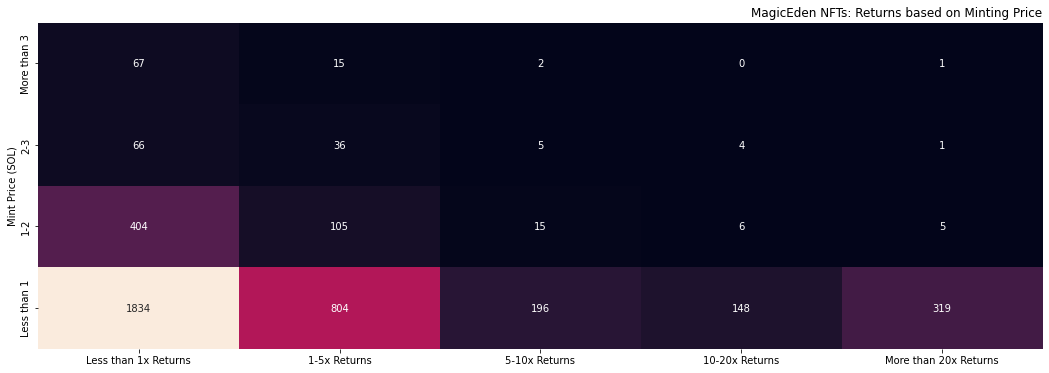

In [17]:
plt.figure(figsize=(18,6))
ax = sns.heatmap(pivoted, annot=True, cbar=False, fmt='g')
ax.invert_yaxis()
plt.title('MagicEden NFTs: Returns based on Minting Price', 
    loc='right',
    size='large'
    )

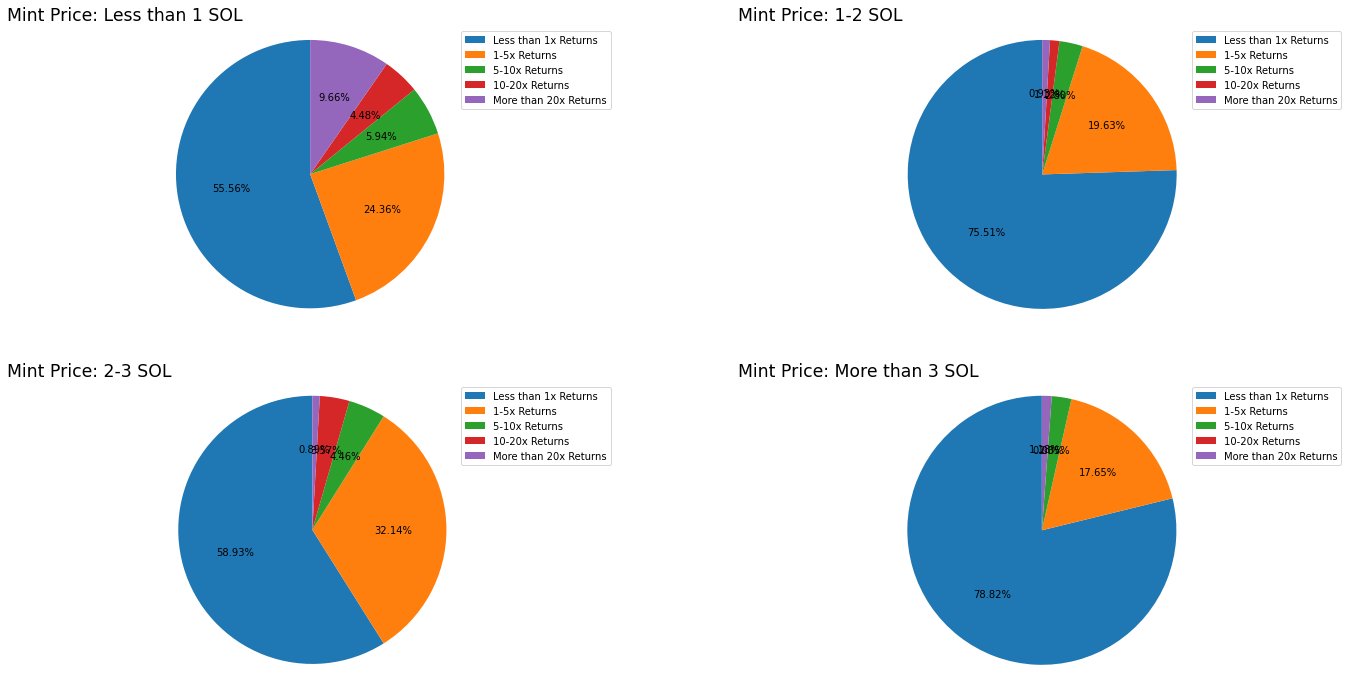

In [34]:
plt.figure(figsize=(24,12), facecolor='white')

labels = pivoted.columns

ax1 = plt.subplot(2,2,1)
slices = pivoted.iloc[0]
plt.pie(slices, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Mint Price: Less than 1 SOL', size='xx-large', loc='left')
plt.legend(labels=labels)

ax2 = plt.subplot(2,2,2)
slices = pivoted.iloc[1]
plt.pie(slices, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Mint Price: 1-2 SOL', size='xx-large', loc='left')
plt.legend(labels=labels)

ax3 = plt.subplot(2,2,3)
slices = pivoted.iloc[2]
plt.pie(slices, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Mint Price: 2-3 SOL', size='xx-large', loc='left')
plt.legend(labels=labels)

ax4 = plt.subplot(2,2,4)
slices = pivoted.iloc[3]
plt.pie(slices, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Mint Price: More than 3 SOL', size='xx-large', loc='left')
plt.legend(labels=labels)

plt.show()